# Import

In [42]:
import xdas as xd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths and directories

In [47]:
# Path to xpick picks
path_to_csv = f"./data/manual_picks/shot_3.csv"
# Path to data
h5_dir = f"./data/shot_das_1/shot_3.nc"

In [48]:
data = xd.open_dataarray(f"{h5_dir}")
picks = pd.read_csv(f"{path_to_csv}", parse_dates=["time"])

# Interpolate picks on cable distances

In [49]:
#Max distance (m) to interpolate within when no picks are found
max_dist = 5.0
picks["time"] = (picks["time"] - np.datetime64(0, "ns")) / np.timedelta64(1, "ns")
dp = xd.DataCollection({})
for phase, df in picks.groupby("phase"):
    df = df.sort_values("distance")
    df = df.drop_duplicates("distance")
    df = df.set_index("distance")["time"]
    da = df.to_xarray()
    d = da["distance"].values
    m = np.diff(d) < max_dist
    (idx,) = np.where(~m)
    start = d[idx]
    end = d[idx + 1]
    da = da.interp(distance=data["distance"].values)
    for k in range(len(idx)):
        da.loc[dict(distance=slice(start[k], end[k]))] = np.nan
    dp[phase] = da

# Save outputs in a dataframe

In [50]:
picks_df = pd.DataFrame()
for phase in dp:
    arr = np.array(dp[phase], dtype='datetime64[ns]')
    time = np.array(arr, dtype='datetime64[ns]')
    time = xd.DataArray(time, {"distance": dp[phase]["distance"].values})
    time.name = "picks"
    interp_df = pd.DataFrame(
        {
            "distance": dp[phase]["distance"].values,
            "picks": time.values,
            "Phase": phase,
        }
    )
    ds = xd.get_sampling_interval(data, dim="distance")
    interp_df["channel"] = interp_df["distance"].values / ds
    interp_df["distance"] = interp_df["distance"].round(2).astype(float)
    interp_df["channel"] = interp_df["channel"].round().astype(int)
    interp_df["Phase"] = phase
    picks_df = pd.concat([picks_df, interp_df], ignore_index=True)

picks_df.to_csv("./data/picks/shot_3.csv", index=False)

# Visualize picks

In [51]:
# -- Axes --
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["axes.axisbelow"] = False
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.ymargin"] = 0.1
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 300
# -- Ticks and tick labels --
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["ytick.minor.size"] = 1
# -- Fonts --
plt.rcParams["font.size"] = 10
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["axes.labelsize"] = 10
# -- Saving Options --
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.transparent"] = False
# -- Plot Styles --
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 0.1
plt.rcParams["lines.markeredgewidth"] = 0.1
plt.rcParams["figure.dpi"] = 300

mm = 1 / 25.4

In [53]:
picks_df_open = pd.read_csv("./data/picks/shot_3.csv", parse_dates=["picks"])

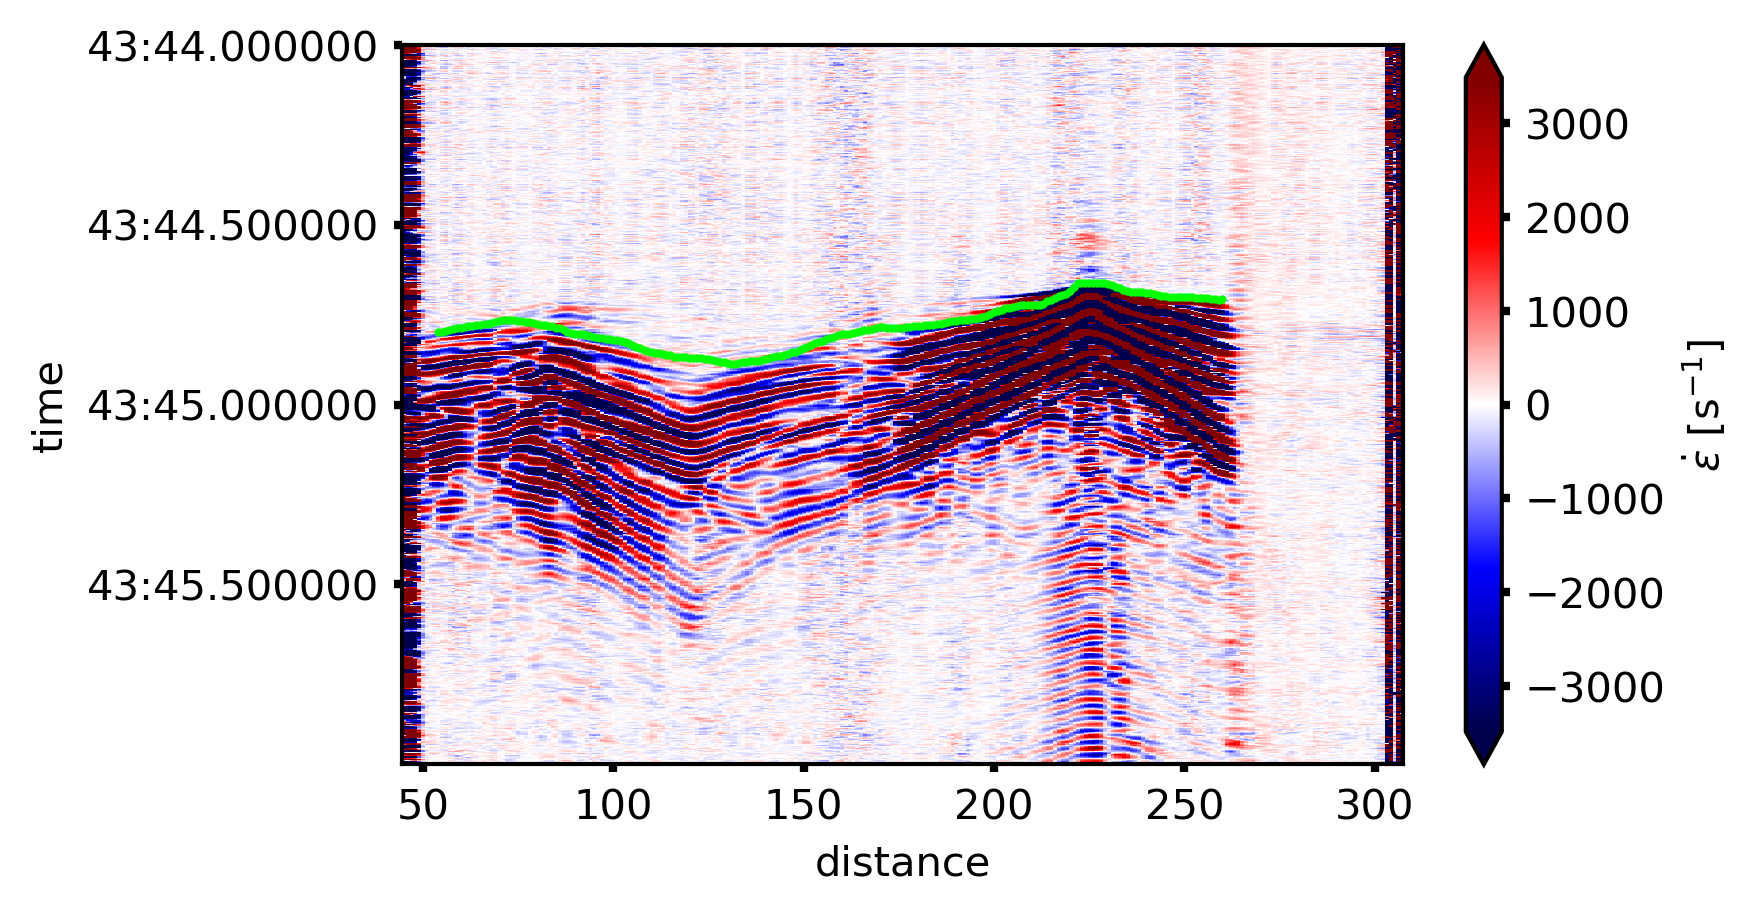

In [56]:
vlim = np.nanpercentile(np.abs(data.values), 90)
fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(150*mm, 80*mm),
    dpi=300
)
ax = axes
data.plot(robust=True,
    yincrease=False,
    vmin=-vlim, vmax=vlim,
    ax=ax, 
    cmap="seismic", 
    cbar_kwargs={
        "label": r"$\dot{\varepsilon}$ [s$^{-1}$]",
    })
ax.scatter(picks_df_open[picks_df_open["Phase"] == "P"]["distance"],
              picks_df_open[picks_df_open["Phase"] == "P"]["picks"],
              s=1,
              label="Phase P",
              color="lime"
)
ax.scatter(picks_df_open[picks_df_open["Phase"] == "S"]["distance"],
              picks_df_open[picks_df_open["Phase"] == "S"]["picks"],
              s=1,
              label="Phase S",
              color="orange"
)   
fig.tight_layout()
fig.savefig("./output/shot_3.png", dpi=600)